In [1]:
#####################################################################
# Importing, processing, and reshaping the surface EMG data
# Ladislas Nalborczyk
# Last updated on March 8, 2021
################################################################

# clear all variables
%reset -f

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat # data import
from scipy.io.wavfile import write
import glob # data import
import librosa # signal processing
import librosa.display # spectrograms
import ipywidgets as widgets # interactive widgets
from ipywidgets import interact, interactive, interact_manual # interactive widgets
from IPython.display import display, clear_output
import sounddevice as sd # playing audio signals
import pandas as pd # datafames

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # show all code cells outputs

import os
from IPython.display import Image, display, HTML

# import custom modules
from importlib import reload  
import emg_modules as emg
reload(emg)

<module 'emg_modules' from '/Users/Ladislas/Desktop/surface_emg_cnn/emg_modules.py'>

In [2]:
# importing all .mat data files into "data"
data, data_files = emg.import_data(data_dir = "data/")

# prints all variables
print("-" * 60, "\n", "List of extant variables:", data[0].keys() )

Successfully imported data for 22 participants
------------------------------------------------------------ 
 List of extant variables: dict_keys(['data', 'datastart', 'dataend', 'titles', 'rangemin', 'rangemax', 'unittext', 'unittextmap', 'blocktimes', 'tickrate', 'samplerate', 'firstsampleoffset', 'comtext', 'com'])


In [3]:
########################################
# Import data for each participant
#####################################

for i in range(len(data) ):
    
    # prints progress
    print("Processing participant", data_files[i][-8:])
    
    # for each participant, data is stored in a dictionary
    data_ppt = data[i]
    data_emg_tmp = data_ppt["data"]
    data_start_emg = data_ppt["datastart"]
    data_end_emg = data_ppt["dataend"]
    tick_rate = int(data_ppt["tickrate"][0][0])
    sample_rate_emg = np.unique(data_ppt["samplerate"])[0]
    titles_emg = data_ppt["titles"]
    com_emg = data_ppt["com"]
    com_text = data_ppt["comtext"]
    nb_repet = 6

    # gets the number of channels
    num_channels = len(titles_emg)

    # gets the number of samples
    # num_samples = int(data_end_emg[0, 0] - data_start_emg[0, 0])
    num_samples = int(len(data_emg_tmp[0]) / num_channels)
    print("Total number of samples:", num_samples)
    print("Sampling rate is", int(sample_rate_emg), "Hz")
    
    # initialises an empty numpy array with N time frames * X channels (i.e., muscles)
    data_EMG = np.zeros((int(len(data_emg_tmp[0]) / num_channels), num_channels) )

    # for each channel
    # for j in range(num_channels):
    #         raw_data = data_emg_tmp[0, int(data_start_emg[j][0])-1:int(data_end_emg[j][0])-1]
    #         data_EMG[:, j] = raw_data

    a, b, c, d, e = np.split(ary = data_emg_tmp, indices_or_sections = 5, axis = 1)
    data_EMG[:, 0] = a[0]
    data_EMG[:, 1] = b[0]
    data_EMG[:, 2] = c[0]
    data_EMG[:, 3] = d[0]
    data_EMG[:, 4] = e[0]
    
    # checks data shape
    print("EMG matrix is of shape", data_EMG.shape)
    
    # reshapes triggers matrix
    com_emg, com_relax = emg.trigger_formatting(com_emg, com_text, tick_rate, sample_rate_emg)

    # import trigger values
    com_emg = emg.import_trigger_values(com_emg = com_emg, num_sujet = data_files[i][-8:-4])
    # print(com_emg.shape)
    
    # assembling triggers
    trigger, trigger_values = emg.assembling_trigger(
        data_EMG = data_EMG, com_emg = com_emg, com_relax = com_relax,
        emg_sr = sample_rate_emg, titles_emg = titles_emg
    )
    
    # processing the EMG signal
    data_EMG, trigger, times_word = emg.emg_processing(data_EMG, trigger, com_emg, trigger_values, nb_repet, titles_emg, sample_rate_emg)
    
    # 3D EMG data matrix (6s signals, 5 muscles, 60 triggers) with only speech portions
    # print(trigger.shape)

    # reshapes this in a dataframe with triggers in rows and muscles in columns
    # trigger = np.column_stack([trigger, sorted(trigger_values.tolist() * int(sample_rate_emg) )])
    # print(trigger.shape)
    # trigger.reshape(6000, -1).shape

    babar = np.reshape(a = trigger, newshape = (6000 * 60, 5), order = "F")
    # print(babar.shape)

    # from https://stackoverflow.com/questions/33211988/python-reshape-3d-array-into-2d
    babar = trigger.transpose(2, 0, 1).reshape(-1, trigger.shape[1])
    babar = np.column_stack([babar, sorted(trigger_values.tolist() * int(sample_rate_emg) * int(nb_repet) )])
    emg_df = pd.DataFrame(babar, columns = ["OOI", "ZYG", "FRO", "COR", "FCR", "trigger"])

    emg_df["participant"] = data_files[i][-8:-4]
    # emg_df.head()
    
    if "emg_results" in locals():
        # if emg_results already exists, rowbinding the new one
        # emg_results = np.row_stack([emg_results, emg_df])
        emg_results = pd.concat([emg_results, emg_df], ignore_index = True)
    else:
        # otherwise, creates it
        emg_results = emg_df
        
    print("-" * 80, "\n")

print("Shape of the final array is:", emg_results.shape)
emg_results.head()

Processing participant S_01.mat
Total number of samples: 1339100
Sampling rate is 1000 Hz
EMG matrix is of shape (1339100, 5)
Is there successive trigger values duplicates? False
Trigger occurrences before cleaning: {0.0: 361, 32.0: 3, 64.0: 60, 96.0: 60, 128.0: 60, 160.0: 60, 192.0: 60, 224.0: 60}
Trigger occurrences after cleaning: {64.0: 60, 96.0: 60, 128.0: 60, 160.0: 60, 192.0: 60, 224.0: 60}
Shape of the resulting matrix for the relaxation period is: (60000, 5)
Shape of the resulting matrix for experimental trials is: (6000, 5, 60)
-------------------------------------------------------------------------------- 

Processing participant S_02.mat
Total number of samples: 1427850
Sampling rate is 1000 Hz
EMG matrix is of shape (1427850, 5)
Is there successive trigger values duplicates? False
Trigger occurrences before cleaning: {0.0: 361, 32.0: 2, 64.0: 60, 96.0: 60, 128.0: 60, 160.0: 60, 192.0: 60, 224.0: 60}
Trigger occurrences after cleaning: {64.0: 60, 96.0: 60, 128.0: 60, 160.0

,OOI,ZYG,FRO,COR,FCR,trigger,participant
0,-0.036024,0.014216,0.001860,0.010190,0.000046,1.0,S_01
1,0.000014,0.003965,-0.000549,0.008205,-0.001037,1.0,S_01
2,0.062766,-0.024596,-0.000427,0.009620,-0.002976,1.0,S_01
3,0.113331,-0.025801,-0.001856,0.010660,-0.002712,1.0,S_01
4,0.040279,-0.016294,-0.000355,0.005997,-0.000964,1.0,S_01


In [4]:
# removing duplicated rows?
dup = np.unique(ar = data_EMG, axis = 0)
print(data_EMG.shape, dup.shape)
print("WARNING: There are", sum(emg_results.duplicated() ), "duplicated rows in emg_results...")

# what are the duplicated rows?
# df = emg_results[emg_results.duplicated(keep = False)]
# df = df.groupby(list(df)).apply(lambda x: tuple(x.index)).tolist()
# df.sort()
# print(df[0:50])

(1457100, 5) (1457100, 5)


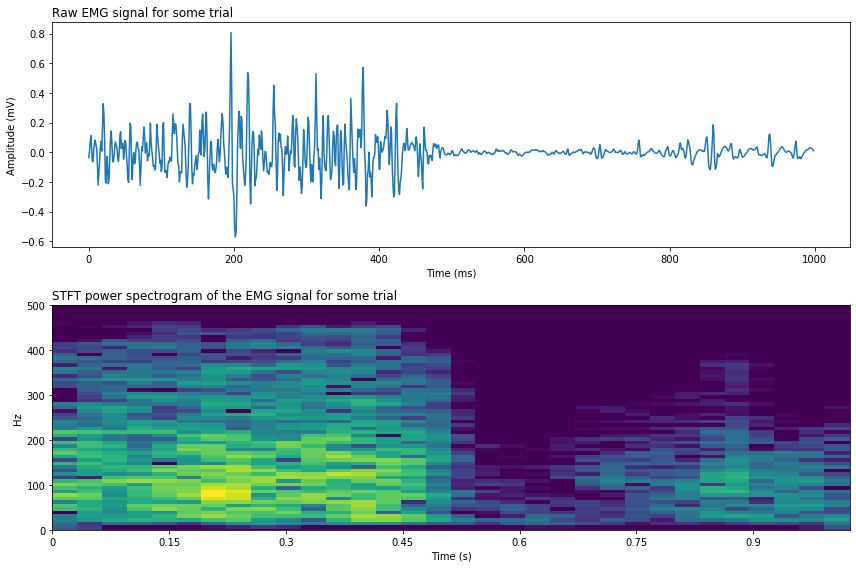

In [5]:
# extracting the signal for the first trial and first muscle
emg_signal = emg_results.iloc[0:999, 0].to_numpy()

# plotting the raw signal and the spectrogram for this trial
# reload(emg)
emg.plot_spectrogram(signal = emg_signal, sr = sample_rate_emg, n_fft = 128, window = "hamming", win_length = 128, hop_length = 32)

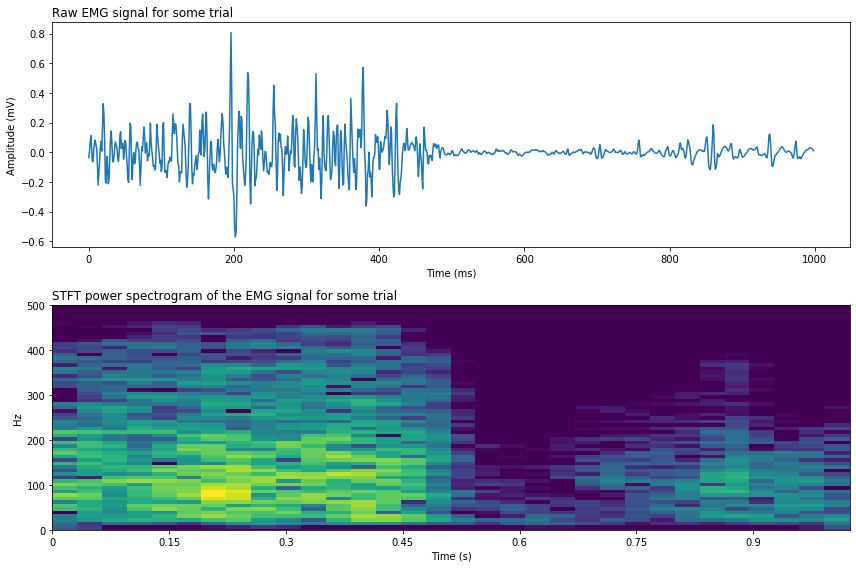

In [393]:
########################################
# Interactive plotting
###################################

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # show all code cells outputs

ppt_list = np.unique(emg_results["participant"])

def f(muscle, trigger, participant):
    
    # extracting the phrase selected by the user
    # phrase = data[int(ph)]
    
    # extracting the signal for the first trial and first muscle
    emg_signal = emg_results.iloc[0:999, 0].to_numpy()

    # plotting the raw signal and the spectrogram for this trial
    emg.plot_spectrogram(signal = emg_signal, sr = sample_rate_emg, n_fft = 128, window = "hamming", win_length = 128, hop_length = 32)

############################
# plotting
######################
    
interactive_plot = interactive(
    f,
    muscle = titles_emg,
    trigger = trigger_values, # [str(i) for i in range(118)],
    participant = ppt_list # [str(i) for i in range(1, 261)]
    )

interactive_plot

In [6]:
#####################################################################
# Saves data to a .csv file
# NB:long command, the resulting csv file is around 1.2Go...
#################################################################

emg_results.to_csv(path_or_buf = "data/filtered_centered_emg_data.csv", index = False)